# MIP Control

In [81]:
import sys
sys.path.append('..')

In [82]:
%matplotlib notebook  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [83]:
from ctrl.system.tf import PID
from ctrl.block.linear import MIMO, ShortCircuit, Subtract
from ctrl.block.logger import Logger
from ctrl.block.nl import Abs
from ctrl.block.logic import CompareAbs, Trigger
from ctrl.system.tf import DTTF
from ctrl.system.ss import DTSS

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [84]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
#HOST, PORT = "192.168.12.197", 9999
mip = Controller(host = HOST, port = PORT)

## Probe the controller

In [85]:
print(mip.info('all'))

> Controller with 6 device(s), 8 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu
  6. is_running
  7. motor1
  8. motor2
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[Inclinometer, enabled] >> imu
> filters
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2[Motor, enabled]



## Closed-loop Control

In [86]:
mip.add_signal('theta_reference')
mip.add_signal('phi_reference')
mip.add_signal('voltage')

thetag = -0.07
mip.set_signal('theta_reference', thetag)
mip.set_signal('phi_reference', 0)

mip.add_signal('theta_error')
mip.add_signal('phi_error')

mip.add_filter('sub_theta', 
               Subtract(),
               ['imu','theta_reference'], 
               ['theta_error'])

mip.add_filter('sub_phi', 
               Subtract(),
               ['encoder1','phi_reference'], 
               ['phi_error'])

In [87]:
mip.add_signal('control_input_theta')
mip.add_signal('control_input_phi')
mip.add_signal('trigger_signal')

mip.add_filter('compare', 
               CompareAbs(threshold = 5/360),
               ['theta_error'], 
               ['trigger_signal'])

mip.add_filter('trigger', 
               Trigger(threshold = 0.5),
               ['trigger_signal','theta_error', 'phi_error'], 
               ['control_input_theta','control_input_phi'])

In [88]:
Ac = np.array([[4.2503e-01, 2.3048e-01, 1.3251e-01],
               [-1.1192e-01, 8.6164e-01, -2.1370e-01],
               [1.5825e-01, 1.1857e-01, 2.9377e-01]])
Bc = 2*np.pi*np.array([[3.2935e-01, 5.1426e-02],
                       [1.0475e-02, -8.5130e-02],
                       [-2.0339e-02, 5.3564e-04]])
Cc = np.array([[-1.3046e+01, 2.2335e+00, 3.6255e+00]])
Dc = 2*np.pi*np.array([[0,0]])

Bc = (100/7.4)*Bc
Dc = (100/7.4)*Dc

ctrl = DTSS(Ac,Bc,Cc,Dc)

In [89]:
mip.add_filter('controller', 
               MIMO(ctrl),
               ['control_input_theta','control_input_phi'], 
               ['voltage'])
mip.add_filter('cl1',
                ShortCircuit(),
               ['voltage'],
               ['motor1'])
mip.add_filter('cl2',
                ShortCircuit(),
               ['voltage'],
               ['motor2'])

In [90]:
mip.add_sink('logger', Logger(), ['clock','imu','motor1','motor2','encoder1','encoder2','voltage','duty','theta_error','phi_error','trigger_signal','control_input_theta','control_input_phi'])

In [91]:
print(mip.info('all'))

> Controller with 6 device(s), 16 signal(s), 4 source(s), 3 sink(s), and 7 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. control_input_phi
  3. control_input_theta
  4. duty
  5. encoder1
  6. encoder2
  7. imu
  8. is_running
  9. motor1
  10. motor2
  11. phi_error
  12. phi_reference
  13. theta_error
  14. theta_reference
  15. trigger_signal
  16. voltage
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[Inclinometer, enabled] >> imu
> filters
  1. imu, theta_reference >> sub_theta[Subtract, enabled] >> theta_error
  2. encoder1, phi_reference >> sub_phi[Subtract, enabled] >> phi_error
  3. theta_error >> compare[CompareAbs, enabled] >> trigger_signal
  4. trigger_signal, theta_error, phi_error >> trigger[Trigger, enabled] >> control_input_theta, control_input_phi
  5. contro

In [92]:
mip.set_sink('logger',reset=True)
mip.set_source('clock',reset=True)
mip.set_source('encoder1',reset=True)
mip.set_source('encoder2',reset=True)
mip.set_filter('controller',reset=True)
mip.set_filter('trigger',reset=True)
with mip:
    time.sleep(20)
log = mip.read_sink('logger')

In [93]:
clock = log[:,0]
theta = log[:,1]
motor1 = log[:,2]
motor2 = log[:,3]
encoder1 = log[:,4]
encoder2 = log[:,5]
voltage = log[:,6]
duty = log[:,7]
theta_error = log[:,8]
phi_error = log[:,9]
trigger_signal = log[:,10]
control_input_theta = log[:,11]
control_input_phi = log[:,12]

data = {
    'clock': clock,
    'theta': theta,
    'encoder1': encoder1,
    'encoder2': encoder2,
    'voltage': voltage,
    'trigger_signal': trigger_signal
}

<IPython.core.display.Javascript object>


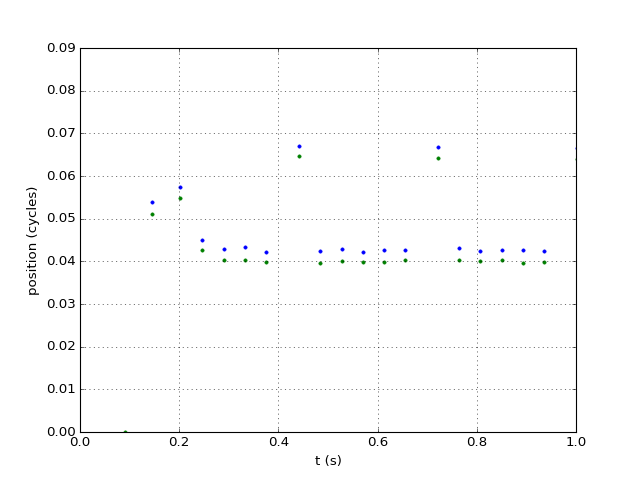

(0, 1)

In [95]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock[1:],clock[1:]-clock[:-1], '.',clock,duty,'.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
plt.xlim(0,1)

<IPython.core.display.Javascript object>


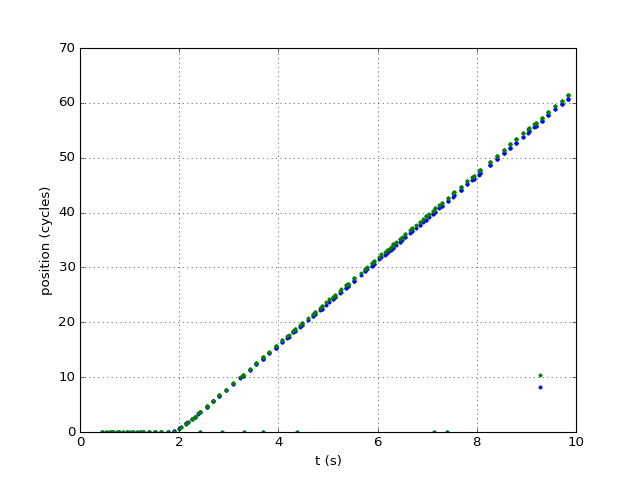

In [79]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,encoder1,'b.',clock,encoder2,'g.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
#plt.xlim(0,3)

<IPython.core.display.Javascript object>


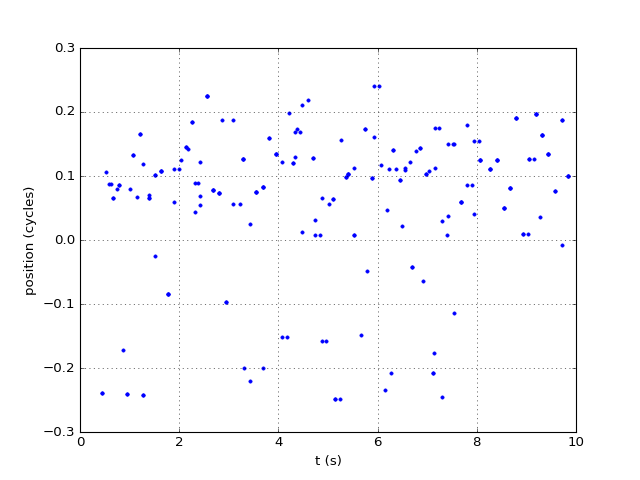

In [80]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,theta,'b.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
#plt.xlim(0,3)

<IPython.core.display.Javascript object>


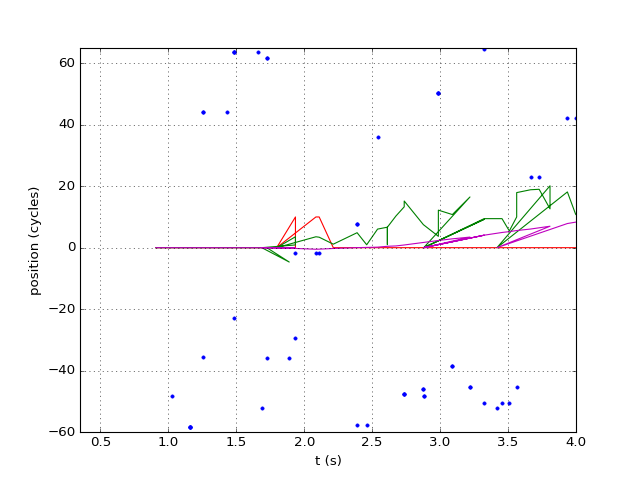

(-60, 65)

In [50]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,theta_error*360,'b.',
         clock,10*trigger_signal,'r',
         clock,7.4*voltage/100,'g',
         clock,encoder1,'m'
        )
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()
plt.xlim(0.35,4)
plt.ylim(-60,65)

<IPython.core.display.Javascript object>


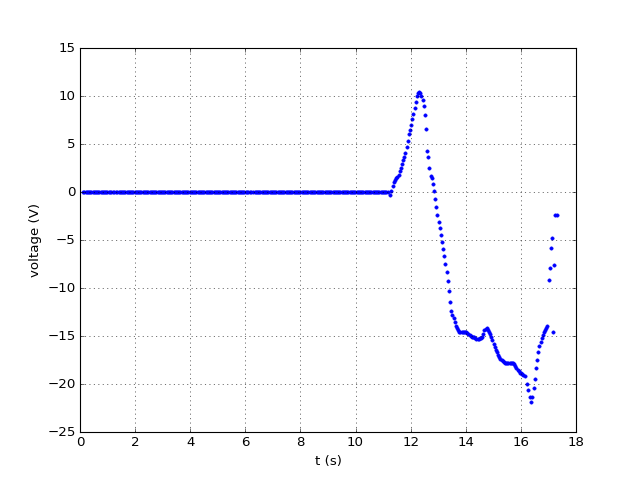

In [20]:
fig = plt.figure()

#plt.plot(clock, imu, clock, encoder1, clock, encoder2, clock, voltage)
plt.plot(clock,(7.4/100)*voltage,'b.')
plt.xlabel('t (s)')
plt.ylabel('voltage (V)')
plt.grid()
#plt.xlim(0,3)

In [21]:
import scipy.io as spio
spio.savemat(file_name='/home/mauricio/Dropbox/ZhuZhuo/python', mdict = data)